In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Paths to left and right images
left_image_path = '/content/drive/MyDrive/Assignment02_Disparity_and_Depth/triclopsi2l.jpg'
right_image_path = '/content/drive/MyDrive/Assignment02_Disparity_and_Depth/triclopsi2r.jpg'
left_image_path1 = '/content/drive/MyDrive/Assignment02_Disparity_and_Depth/corridorl.jpg'
right_image_path1 = '/content/drive/MyDrive/Assignment02_Disparity_and_Depth/corridorr.jpg'
ground_truth_path='/content/drive/MyDrive/Assignment02_Disparity_and_Depth/GTLegit.png'

In [ ]:
!pip3 install progress progressbar2 alive-progress tqdm

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.4/68.4 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 kB 7.4 MB/s eta 0:00:00
  Created wheel for progress: filename=progress-1.6-py3-none-any.whl size=9613 sha256=7ad853edde7309860a806e12f9fcff3168c472cc41ee87635e4d162237b8729b
  Stored in directory: /root/.cache/pip/wheels/a2/68/5f/c339b20a41659d856c93ccdce6a33095493eb82c3964aac5a1
  Created wheel for grapheme: filename=grapheme-0.6.0-py3-none-any.whl size=210082 sha256=fe61d48e933ea6880ba988ee7b97ec60e2f3ec111db66c3d69bed0e7e09a68fd
  Stored in directory: /root/.cache/pip/wheels/01/e1/49/37e6bde9886439057450c494a79b0bef8bbe897a54aebfc757
Successfully built progress grapheme


In [ ]:
import numpy as np
import math
import cv2 as cv
import matplotlib.pyplot as plt
from progress.bar import Bar

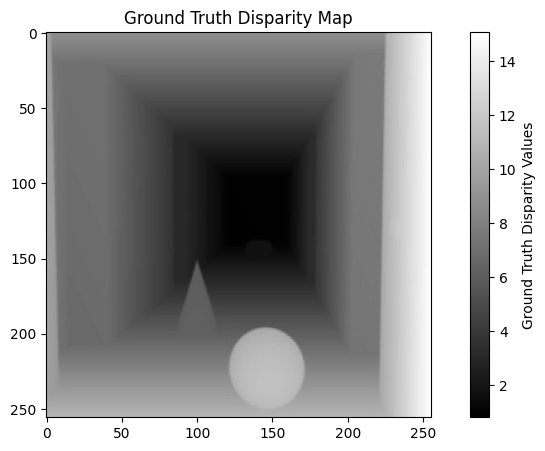

Ground Truth Disparity values at specific coordinates:
Disparity at (0, 0): 9.875
Disparity at (0, 50): 8.75
Disparity at (0, 100): 8.75
Disparity at (0, 150): 8.75
Disparity at (0, 200): 8.75
Disparity at (0, 250): 14.1875
Disparity at (50, 0): 9.8125
Disparity at (50, 50): 6.1875
Disparity at (50, 100): 4.6875
Disparity at (50, 150): 4.6875
Disparity at (50, 200): 6.875
Disparity at (50, 250): 14.25
Disparity at (100, 0): 9.8125
Disparity at (100, 50): 6.1875
Disparity at (100, 100): 2.4375
Disparity at (100, 150): 0.9375
Disparity at (100, 200): 6.9375
Disparity at (100, 250): 14.25
Disparity at (150, 0): 9.8125
Disparity at (150, 50): 6.125
Disparity at (150, 100): 2.5
Disparity at (150, 150): 1.75
Disparity at (150, 200): 6.9375
Disparity at (150, 250): 14.25
Disparity at (200, 0): 9.75
Disparity at (200, 50): 6.125
Disparity at (200, 100): 6.25
Disparity at (200, 150): 10.5
Disparity at (200, 200): 6.9375
Disparity at (200, 250): 14.3125
Disparity at (250, 0): 10.4375
Disparity a

In [ ]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

# Load the ground truth disparity map
imgGroundTruth = cv.imread(ground_truth_path, cv.IMREAD_GRAYSCALE)

# Check if the image loaded successfully
if imgGroundTruth is None:
    raise ValueError("Failed to load the ground truth image.")

# Convert the ground truth to float32 for accurate value display and divide by 16.0 (if needed)
imgGroundTruth = imgGroundTruth.astype(np.float32) / 16.0

# Display the ground truth disparity map
plt.figure(figsize=(10, 5))
plt.imshow(imgGroundTruth, cmap='gray')
plt.colorbar(label='Ground Truth Disparity Values')
plt.title('Ground Truth Disparity Map')
plt.show()

# Print specific disparity values for a range of coordinates
height, width = imgGroundTruth.shape
print("Ground Truth Disparity values at specific coordinates:")
for y in range(0, height, 50):  # Every 50th row
    for x in range(0, width, 50):  # Every 50th column
        print(f"Disparity at ({y}, {x}): {imgGroundTruth[y, x]}")

# If you want to print all the ground truth disparity values (might be too many), uncomment below:
# print("All Ground Truth Disparity Values in the map:")
# print(imgGroundTruth)


Baseline no pre-processing
==

block size:  15 max disparity:  16


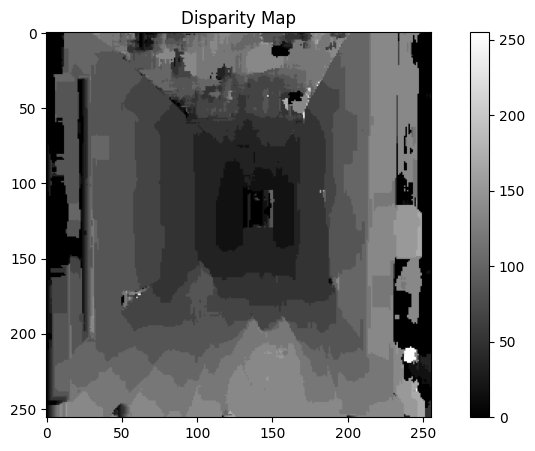

BMP (Bad Matched Pixels): 57.88%
MSE (Mean Squared Error): 14.8727
MRE (Mean Relative Error): 0.2811
SZE (Subpixel Zero Error): 19.94%
MAE (Mean Absolute Error): 2.2831
DRC (Disparity Range Coverage for 1 to 255): 91.79%


In [ ]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
from progress.bar import Bar  # For progress bar during disparity map computation

# Define SAD and SSD functions
def sad(left_block, right_block):
    return np.sum(np.abs(right_block - left_block))

def ssd(left_block, right_block):
    return np.sum(np.square(right_block - left_block))

def SobelFilter(image):
    height, width = image.shape
    out_image = np.zeros((height, width))

    table_x = np.array(([-1, -2, -1], [0, 0, 0], [1, 2, 1]))
    table_y = np.array(([-1, 0, 1], [-2, 0, 2], [-1, 0, 1]))

    for y in range(2, width - 2):
        for x in range(2, height - 2):
            cx, cy = 0, 0
            for offset_y in range(0, 3):
                for offset_x in range(0, 3):
                    pix = image[x + offset_x - 1, y + offset_y - 1]
                    if offset_x != 1:
                        cx += pix * table_x[offset_x, offset_y]
                    if offset_y != 1:
                        cy += pix * table_y[offset_x, offset_y]
            out_pix = math.sqrt(cx**2 + cy**2)
            out_image[x, y] = out_pix if out_pix > 0 else 0
    np.putmask(out_image, out_image > 255, 255)
    return out_image

def PreProcessing(img_left, img_right, filter=SobelFilter):
    sobel_left = filter(img_left)
    sobel_right = filter(img_right)
    return sobel_left, sobel_right

# Function to compute the disparity map
def disparity_map(left_img, right_img, max_disparity, block_size, matching_func=ssd):
    height, width = left_img.shape
    res = np.zeros((height, width), dtype=np.float32)
    half_block = block_size // 2

    left_img_padded = np.pad(left_img, ((half_block, half_block), (half_block, half_block)), mode='edge')
    right_img_padded = np.pad(right_img, ((half_block, half_block), (half_block, half_block)), mode='edge')

    max_height = height + half_block
    max_width = width + half_block

    with Bar('Processing...') as bar:
        for y in range(half_block, max_height):
            bar.next()
            for x in range(half_block, max_width):
                best_similarity = float('inf')
                best_offset = 0

                left_block = left_img_padded[y - half_block:y + half_block + 1, x - half_block:x + half_block + 1]

                for offset in range(max_disparity):
                    right_x = x - offset
                    if right_x < half_block:
                        break

                    right_block = right_img_padded[y - half_block:y + half_block + 1, right_x - half_block:right_x + half_block + 1]
                    sim = matching_func(left_block, right_block)

                    if sim < best_similarity:
                        best_similarity = sim
                        best_offset = offset

                res[y - half_block, x - half_block] = best_offset

    return res

# Function to calculate evaluation metrics (BMP, MSE, MRE, SZE, MAE, DRC)
def calculate_metrics(disparity, imgGroundTruth):
    disparity = disparity.astype(np.float32)/16
    imgGroundTruth = imgGroundTruth.astype(np.float32)/16

    valid_mask = imgGroundTruth > 0

    # BMP (Bad Matched Pixels)
    error_threshold = 1.0
    bmp = np.sum(np.abs(disparity[valid_mask] - imgGroundTruth[valid_mask]) > error_threshold) / np.sum(valid_mask)
    print(f"BMP (Bad Matched Pixels): {bmp * 100:.2f}%")

    # MSE (Mean Squared Error)
    mse = np.mean((disparity[valid_mask] - imgGroundTruth[valid_mask]) ** 2)
    print(f"MSE (Mean Squared Error): {mse:.4f}")

    # MRE (Mean Relative Error)
    mre = np.mean(np.abs(disparity[valid_mask] - imgGroundTruth[valid_mask]) / (np.abs(imgGroundTruth[valid_mask]) + 1e-5))
    print(f"MRE (Mean Relative Error): {mre:.4f}")

    # SZE (Subpixel Zero Error)
    sze = np.sum(np.abs(disparity[valid_mask] - imgGroundTruth[valid_mask]) < 0.5) / np.sum(valid_mask)
    print(f"SZE (Subpixel Zero Error): {sze * 100:.2f}%")

    # MAE (Mean Absolute Error)
    mae = np.mean(np.abs(disparity[valid_mask] - imgGroundTruth[valid_mask]))
    print(f"MAE (Mean Absolute Error): {mae:.4f}")

    # DRC (Disparity Range Coverage)
    min_disparity = 1  # Set minimum disparity to 1
    max_disparity = 255  # Set maximum disparity to 255

    # Calculate valid disparities within the specified range (1 to 255)
    valid_disparities = (disparity >= min_disparity) & (disparity <= max_disparity)
    total_pixels = disparity.size
    covered_pixels = np.sum(valid_disparities)

    # Calculate DRC percentage
    drc = (covered_pixels / total_pixels) * 100
    print(f"DRC (Disparity Range Coverage for 1 to 255): {drc:.2f}%")


# Load images
left_image = cv.imread('/content/drive/MyDrive/Assignment02_Disparity_and_Depth/corridorl.jpg', cv.IMREAD_GRAYSCALE)
right_image = cv.imread('/content/drive/MyDrive/Assignment02_Disparity_and_Depth/corridorr.jpg', cv.IMREAD_GRAYSCALE)
imgGroundTruth = cv.imread(ground_truth_path, cv.IMREAD_GRAYSCALE)

# Preprocess the left and right images
left_image, right_image = PreProcessing(left_image, right_image, SobelFilter)

# Grid search for block size and max disparity
for md in [16]:
    for bs in [15]:
        if bs > md:
            continue
        print("block size: ", bs, "max disparity: ", md)

        # Compute disparity map
        dmap = disparity_map(left_image, right_image, md, bs, ssd)

        # Normalize the disparity map for display
        dmap_normalized = cv.normalize(dmap, None, 0, 255, cv.NORM_MINMAX)
        dmap_normalized = np.uint8(dmap_normalized)

        # Display the disparity map
        plt.figure(figsize=(10, 5))
        plt.imshow(dmap_normalized, cmap='gray')
        plt.title('Disparity Map')
        plt.colorbar()
        plt.show()

        # Compute and display evaluation metrics
        calculate_metrics(dmap_normalized, imgGroundTruth)


block size:  15 max disparity:  16
Disparity Values (sample):
[[2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]]


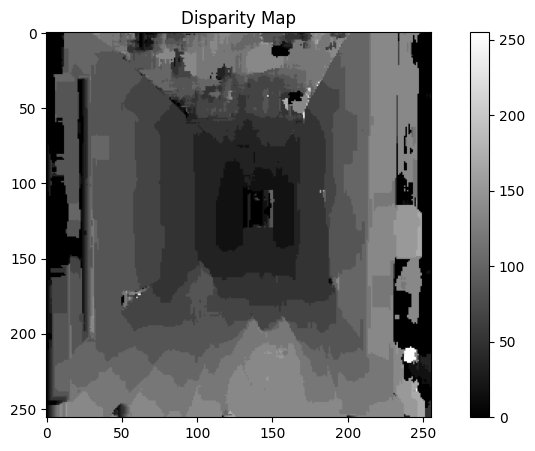

BMP (Bad Matched Pixels): 57.88%
MSE (Mean Squared Error): 14.8727
MRE (Mean Relative Error): 0.2811
SZE (Subpixel Zero Error): 19.94%
MAE (Mean Absolute Error): 2.2831
DRC (Disparity Range Coverage for 1 to 255): 91.79%


In [ ]:
# Load images
left_image = cv.imread('/content/drive/MyDrive/Assignment02_Disparity_and_Depth/corridorl.jpg', cv.IMREAD_GRAYSCALE)
right_image = cv.imread('/content/drive/MyDrive/Assignment02_Disparity_and_Depth/corridorr.jpg', cv.IMREAD_GRAYSCALE)
imgGroundTruth = cv.imread(ground_truth_path, cv.IMREAD_GRAYSCALE)

# Preprocess the left and right images
left_image, right_image = PreProcessing(left_image, right_image, SobelFilter)

# Grid search for block size and max disparity
for md in [16]:
    for bs in [15]:
        if bs > md:
            continue
        print("block size: ", bs, "max disparity: ", md)

        # Compute disparity map
        dmap = disparity_map(left_image, right_image, md, bs, ssd)

        # Normalize the disparity map for display
        dmap_normalized = cv.normalize(dmap, None, 0, 255, cv.NORM_MINMAX)
        dmap_normalized = np.uint8(dmap_normalized)

        # Print disparity values (optional: print a sample)
        print("Disparity Values (sample):")
        print(dmap[100:110, 100:110])  # Print a 10x10 block from the map for example

        # Display the disparity map
        plt.figure(figsize=(10, 5))
        plt.imshow(dmap_normalized, cmap='gray')
        plt.title('Disparity Map')
        plt.colorbar()
        plt.show()

        # Compute and display evaluation metrics
        calculate_metrics(dmap_normalized, imgGroundTruth)


Baseline, gaussian+HE
==

block size:  15 max disparity:  16


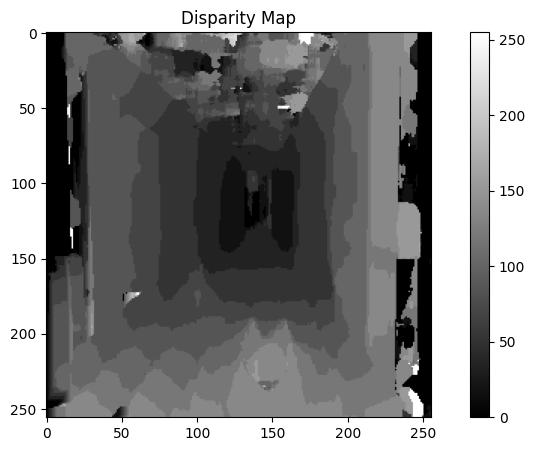

BMP (Bad Matched Pixels): 60.48%
MSE (Mean Squared Error): 16.8044
MRE (Mean Relative Error): 0.3027
SZE (Subpixel Zero Error): 18.52%
MAE (Mean Absolute Error): 2.4672
DRC (Disparity Range Coverage): 100.00%


In [ ]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
from progress.bar import Bar  # For progress bar during disparity map computation

# Define SAD and SSD functions
def sad(left_block, right_block):
    return np.sum(np.abs(right_block - left_block))

def ssd(left_block, right_block):
    return np.sum(np.square(right_block - left_block))

# Apply Histogram Equalization (ensure input is grayscale and 8-bit)
def apply_histogram_equalization(img):
    if img.dtype != np.uint8:
        img = cv.convertScaleAbs(img)  # Convert to 8-bit if not already
    if len(img.shape) == 2:  # Only apply HE if the image is grayscale
        return cv.equalizeHist(img)
    else:
        raise ValueError("Histogram Equalization only works on single-channel grayscale images")

# Apply Gaussian Smoothing
def apply_gaussian_smoothing(img, kernel_size=(5, 5), sigma=1.5):
    return cv.GaussianBlur(img, kernel_size, sigma)
def SobelFilter(image):
    height, width = image.shape
    out_image = np.zeros((height, width))

    table_x = np.array(([-1, -2, -1], [0, 0, 0], [1, 2, 1]))
    table_y = np.array(([-1, 0, 1], [-2, 0, 2], [-1, 0, 1]))

    for y in range(2, width - 2):
        for x in range(2, height - 2):
            cx, cy = 0, 0
            for offset_y in range(0, 3):
                for offset_x in range(0, 3):
                    pix = image[x + offset_x - 1, y + offset_y - 1]
                    if offset_x != 1:
                        cx += pix * table_x[offset_x, offset_y]
                    if offset_y != 1:
                        cy += pix * table_y[offset_x, offset_y]
            out_pix = math.sqrt(cx**2 + cy**2)
            out_image[x, y] = out_pix if out_pix > 0 else 0
    np.putmask(out_image, out_image > 255, 255)
    return out_image
# Preprocess images with HE, Gaussian smoothing, and Sobel filter
def PreProcessing(img_left, img_right, filter=SobelFilter):
    # Apply Histogram Equalization and Gaussian Smoothing
    img_left = apply_histogram_equalization(img_left)
    img_right = apply_histogram_equalization(img_right)
    img_left = apply_gaussian_smoothing(img_left)
    img_right = apply_gaussian_smoothing(img_right)

    # Apply Sobel Filter for edge enhancement
    sobel_left = filter(img_left)
    sobel_right = filter(img_right)
    return sobel_left, sobel_right

# Function to compute the disparity map
def disparity_map(left_img, right_img, max_disparity, block_size, matching_func=ssd):
    height, width = left_img.shape
    res = np.zeros((height, width), dtype=np.float32)
    half_block = block_size // 2

    left_img_padded = np.pad(left_img, ((half_block, half_block), (half_block, half_block)), mode='edge')
    right_img_padded = np.pad(right_img, ((half_block, half_block), (half_block, half_block)), mode='edge')

    max_height = height + half_block
    max_width = width + half_block

    with Bar('Processing...') as bar:
        for y in range(half_block, max_height):
            bar.next()
            for x in range(half_block, max_width):
                best_similarity = float('inf')
                best_offset = 0

                left_block = left_img_padded[y - half_block:y + half_block + 1, x - half_block:x + half_block + 1]

                for offset in range(max_disparity):
                    right_x = x - offset
                    if right_x < half_block:
                        break

                    right_block = right_img_padded[y - half_block:y + half_block + 1, right_x - half_block:right_x + half_block + 1]
                    sim = matching_func(left_block, right_block)

                    if sim < best_similarity:
                        best_similarity = sim
                        best_offset = offset

                res[y - half_block, x - half_block] = best_offset

    return res

# Function to calculate evaluation metrics (BMP, MSE, MRE, SZE, MAE, DRC)
def calculate_metrics(disparity, imgGroundTruth):
    disparity = disparity.astype(np.float32)/16
    imgGroundTruth = imgGroundTruth.astype(np.float32)/16

    valid_mask = imgGroundTruth > 0

    # BMP (Bad Matched Pixels)
    error_threshold = 1.0
    bmp = np.sum(np.abs(disparity[valid_mask] - imgGroundTruth[valid_mask]) > error_threshold) / np.sum(valid_mask)
    print(f"BMP (Bad Matched Pixels): {bmp * 100:.2f}%")

    # MSE (Mean Squared Error)
    mse = np.mean((disparity[valid_mask] - imgGroundTruth[valid_mask]) ** 2)
    print(f"MSE (Mean Squared Error): {mse:.4f}")

    # MRE (Mean Relative Error)
    mre = np.mean(np.abs(disparity[valid_mask] - imgGroundTruth[valid_mask]) / (np.abs(imgGroundTruth[valid_mask]) + 1e-5))
    print(f"MRE (Mean Relative Error): {mre:.4f}")

    # SZE (Subpixel Zero Error)
    sze = np.sum(np.abs(disparity[valid_mask] - imgGroundTruth[valid_mask]) < 0.5) / np.sum(valid_mask)
    print(f"SZE (Subpixel Zero Error): {sze * 100:.2f}%")

    # MAE (Mean Absolute Error)
    mae = np.mean(np.abs(disparity[valid_mask] - imgGroundTruth[valid_mask]))
    print(f"MAE (Mean Absolute Error): {mae:.4f}")

    # DRC (Disparity Range Coverage)
    min_disparity = np.min(disparity[valid_mask])
    max_disparity = np.max(disparity[valid_mask])
    valid_disparities = (disparity >= min_disparity) & (disparity <= max_disparity)
    total_pixels = disparity.size
    covered_pixels = np.sum(valid_disparities)
    drc = (covered_pixels / total_pixels) * 100
    print(f"DRC (Disparity Range Coverage): {drc:.2f}%")

# Load images
left_image = cv.imread('/content/drive/MyDrive/Assignment02_Disparity_and_Depth/corridorl.jpg', cv.IMREAD_GRAYSCALE)
right_image = cv.imread('/content/drive/MyDrive/Assignment02_Disparity_and_Depth/corridorr.jpg', cv.IMREAD_GRAYSCALE)
imgGroundTruth = cv.imread(ground_truth_path, cv.IMREAD_GRAYSCALE)

# Preprocess the left and right images with HE and Gaussian smoothing
left_image, right_image = PreProcessing(left_image, right_image, SobelFilter)

# Grid search for block size and max disparity
for md in [16]:
    for bs in [15]:
        if bs > md:
            continue
        print("block size: ", bs, "max disparity: ", md)

        # Compute disparity map
        dmap = disparity_map(left_image, right_image, md, bs, ssd)

        # Normalize the disparity map for display
        dmap_normalized = cv.normalize(dmap, None, 0, 255, cv.NORM_MINMAX)
        dmap_normalized = np.uint8(dmap_normalized)

        # Display the disparity map
        plt.figure(figsize=(10, 5))
        plt.imshow(dmap_normalized, cmap='gray')
        plt.title('Disparity Map')
        plt.colorbar()
        plt.show()

        # Compute and display evaluation metrics
        calculate_metrics(dmap_normalized, imgGroundTruth)

# Preprocess the left and right images
left_image, right_image = PreProcessing(left_image, right_image, SobelFilter)


baseline, gaussian smoothing
==

block size:  15 max disparity:  16


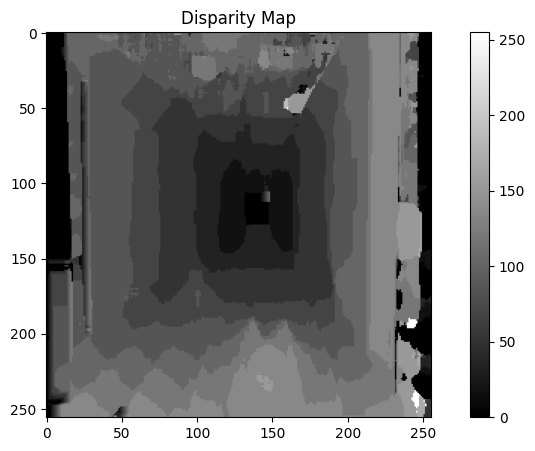

BMP (Bad Matched Pixels): 59.25%
MSE (Mean Squared Error): 13.4046
MRE (Mean Relative Error): 0.2700
SZE (Subpixel Zero Error): 18.79%
MAE (Mean Absolute Error): 2.2022
DRC (Disparity Range Coverage): 100.00%


In [ ]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
from progress.bar import Bar  # For progress bar during disparity map computation

# Define SAD and SSD functions
def sad(left_block, right_block):
    return np.sum(np.abs(right_block - left_block))

def ssd(left_block, right_block):
    return np.sum(np.square(right_block - left_block))

# Apply Histogram Equalization (ensure input is grayscale and 8-bit)
def apply_histogram_equalization(img):
    if img.dtype != np.uint8:
        img = cv.convertScaleAbs(img)  # Convert to 8-bit if not already
    if len(img.shape) == 2:  # Only apply HE if the image is grayscale
        return cv.equalizeHist(img)
    else:
        raise ValueError("Histogram Equalization only works on single-channel grayscale images")

# Apply Gaussian Smoothing
def apply_gaussian_smoothing(img, kernel_size=(5, 5), sigma=1.5):
    return cv.GaussianBlur(img, kernel_size, sigma)

def SobelFilter(image):
    height, width = image.shape
    out_image = np.zeros((height, width))

    table_x = np.array(([-1, -2, -1], [0, 0, 0], [1, 2, 1]))
    table_y = np.array(([-1, 0, 1], [-2, 0, 2], [-1, 0, 1]))

    for y in range(2, width - 2):
        for x in range(2, height - 2):
            cx, cy = 0, 0
            for offset_y in range(0, 3):
                for offset_x in range(0, 3):
                    pix = image[x + offset_x - 1, y + offset_y - 1]
                    if offset_x != 1:
                        cx += pix * table_x[offset_x, offset_y]
                    if offset_y != 1:
                        cy += pix * table_y[offset_x, offset_y]
            out_pix = math.sqrt(cx**2 + cy**2)
            out_image[x, y] = out_pix if out_pix > 0 else 0
    np.putmask(out_image, out_image > 255, 255)
    return out_image
# Preprocess images with HE, Gaussian smoothing, and Sobel filter
def PreProcessing(img_left, img_right, filter=SobelFilter):
    # Apply Gaussian Smoothing
    img_left = apply_gaussian_smoothing(img_left)
    img_right = apply_gaussian_smoothing(img_right)

    # Apply Sobel Filter for edge enhancement
    sobel_left = filter(img_left)
    sobel_right = filter(img_right)
    return sobel_left, sobel_right

# Function to compute the disparity map
def disparity_map(left_img, right_img, max_disparity, block_size, matching_func=ssd):
    height, width = left_img.shape
    res = np.zeros((height, width), dtype=np.float32)
    half_block = block_size // 2

    left_img_padded = np.pad(left_img, ((half_block, half_block), (half_block, half_block)), mode='edge')
    right_img_padded = np.pad(right_img, ((half_block, half_block), (half_block, half_block)), mode='edge')

    max_height = height + half_block
    max_width = width + half_block

    with Bar('Processing...') as bar:
        for y in range(half_block, max_height):
            bar.next()
            for x in range(half_block, max_width):
                best_similarity = float('inf')
                best_offset = 0

                left_block = left_img_padded[y - half_block:y + half_block + 1, x - half_block:x + half_block + 1]

                for offset in range(max_disparity):
                    right_x = x - offset
                    if right_x < half_block:
                        break

                    right_block = right_img_padded[y - half_block:y + half_block + 1, right_x - half_block:right_x + half_block + 1]
                    sim = matching_func(left_block, right_block)

                    if sim < best_similarity:
                        best_similarity = sim
                        best_offset = offset

                res[y - half_block, x - half_block] = best_offset

    return res

# Function to calculate evaluation metrics (BMP, MSE, MRE, SZE, MAE, DRC)
def calculate_metrics(disparity, imgGroundTruth):
    disparity = disparity.astype(np.float32)/16
    imgGroundTruth = imgGroundTruth.astype(np.float32)/16

    valid_mask = imgGroundTruth > 0

    # BMP (Bad Matched Pixels)
    error_threshold = 1.0
    bmp = np.sum(np.abs(disparity[valid_mask] - imgGroundTruth[valid_mask]) > error_threshold) / np.sum(valid_mask)
    print(f"BMP (Bad Matched Pixels): {bmp * 100:.2f}%")

    # MSE (Mean Squared Error)
    mse = np.mean((disparity[valid_mask] - imgGroundTruth[valid_mask]) ** 2)
    print(f"MSE (Mean Squared Error): {mse:.4f}")

    # MRE (Mean Relative Error)
    mre = np.mean(np.abs(disparity[valid_mask] - imgGroundTruth[valid_mask]) / (np.abs(imgGroundTruth[valid_mask]) + 1e-5))
    print(f"MRE (Mean Relative Error): {mre:.4f}")

    # SZE (Subpixel Zero Error)
    sze = np.sum(np.abs(disparity[valid_mask] - imgGroundTruth[valid_mask]) < 0.5) / np.sum(valid_mask)
    print(f"SZE (Subpixel Zero Error): {sze * 100:.2f}%")

    # MAE (Mean Absolute Error)
    mae = np.mean(np.abs(disparity[valid_mask] - imgGroundTruth[valid_mask]))
    print(f"MAE (Mean Absolute Error): {mae:.4f}")

    # DRC (Disparity Range Coverage)
    min_disparity = np.min(disparity[valid_mask])
    max_disparity = np.max(disparity[valid_mask])
    valid_disparities = (disparity >= min_disparity) & (disparity <= max_disparity)
    total_pixels = disparity.size
    covered_pixels = np.sum(valid_disparities)
    drc = (covered_pixels / total_pixels) * 100
    print(f"DRC (Disparity Range Coverage): {drc:.2f}%")

# Load images
left_image = cv.imread('/content/drive/MyDrive/Assignment02_Disparity_and_Depth/corridorl.jpg', cv.IMREAD_GRAYSCALE)
right_image = cv.imread('/content/drive/MyDrive/Assignment02_Disparity_and_Depth/corridorr.jpg', cv.IMREAD_GRAYSCALE)
imgGroundTruth = cv.imread(ground_truth_path, cv.IMREAD_GRAYSCALE)

# Preprocess the left and right images with HE and Gaussian smoothing
left_image, right_image = PreProcessing(left_image, right_image, SobelFilter)

# Grid search for block size and max disparity
for md in [16]:
    for bs in [15]:
        if bs > md:
            continue
        print("block size: ", bs, "max disparity: ", md)

        # Compute disparity map
        dmap = disparity_map(left_image, right_image, md, bs, ssd)

        # Normalize the disparity map for display
        dmap_normalized = cv.normalize(dmap, None, 0, 255, cv.NORM_MINMAX)
        dmap_normalized = np.uint8(dmap_normalized)

        # Display the disparity map
        plt.figure(figsize=(10, 5))
        plt.imshow(dmap_normalized, cmap='gray')
        plt.title('Disparity Map')
        plt.colorbar()
        plt.show()

        # Compute and display evaluation metrics
        calculate_metrics(dmap_normalized, imgGroundTruth)

# Preprocess the left and right images
left_image, right_image = PreProcessing(left_image, right_image, SobelFilter)


baseline, HE
==

block size:  15 max disparity:  16


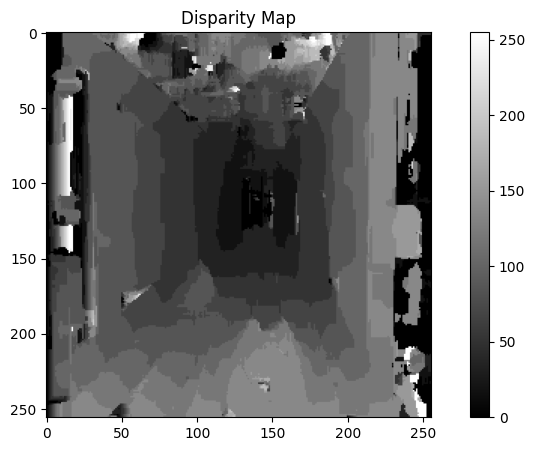

BMP (Bad Matched Pixels): 58.78%
MSE (Mean Squared Error): 15.5862
MRE (Mean Relative Error): 0.2941
SZE (Subpixel Zero Error): 19.18%
MAE (Mean Absolute Error): 2.3693
DRC (Disparity Range Coverage): 100.00%


In [ ]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
from progress.bar import Bar  # For progress bar during disparity map computation

# Define SAD and SSD functions
def sad(left_block, right_block):
    return np.sum(np.abs(right_block - left_block))

def ssd(left_block, right_block):
    return np.sum(np.square(right_block - left_block))

# Apply Histogram Equalization (ensure input is grayscale and 8-bit)
def apply_histogram_equalization(img):
    if img.dtype != np.uint8:
        img = cv.convertScaleAbs(img)  # Convert to 8-bit if not already
    if len(img.shape) == 2:  # Only apply HE if the image is grayscale
        return cv.equalizeHist(img)
    else:
        raise ValueError("Histogram Equalization only works on single-channel grayscale images")

# Apply Gaussian Smoothing
def apply_gaussian_smoothing(img, kernel_size=(5, 5), sigma=1.5):
    return cv.GaussianBlur(img, kernel_size, sigma)

def SobelFilter(image):
    height, width = image.shape
    out_image = np.zeros((height, width))

    table_x = np.array(([-1, -2, -1], [0, 0, 0], [1, 2, 1]))
    table_y = np.array(([-1, 0, 1], [-2, 0, 2], [-1, 0, 1]))

    for y in range(2, width - 2):
        for x in range(2, height - 2):
            cx, cy = 0, 0
            for offset_y in range(0, 3):
                for offset_x in range(0, 3):
                    pix = image[x + offset_x - 1, y + offset_y - 1]
                    if offset_x != 1:
                        cx += pix * table_x[offset_x, offset_y]
                    if offset_y != 1:
                        cy += pix * table_y[offset_x, offset_y]
            out_pix = math.sqrt(cx**2 + cy**2)
            out_image[x, y] = out_pix if out_pix > 0 else 0
    np.putmask(out_image, out_image > 255, 255)
    return out_image
# Preprocess images with HE, Gaussian smoothing, and Sobel filter
def PreProcessing(img_left, img_right, filter=SobelFilter):
    # Apply Histogram Equalization
    img_left = apply_histogram_equalization(img_left)
    img_right = apply_histogram_equalization(img_right)
    # Apply Sobel Filter for edge enhancement
    sobel_left = filter(img_left)
    sobel_right = filter(img_right)
    return sobel_left, sobel_right

# Function to compute the disparity map
def disparity_map(left_img, right_img, max_disparity, block_size, matching_func=ssd):
    height, width = left_img.shape
    res = np.zeros((height, width), dtype=np.float32)
    half_block = block_size // 2

    left_img_padded = np.pad(left_img, ((half_block, half_block), (half_block, half_block)), mode='edge')
    right_img_padded = np.pad(right_img, ((half_block, half_block), (half_block, half_block)), mode='edge')

    max_height = height + half_block
    max_width = width + half_block

    with Bar('Processing...') as bar:
        for y in range(half_block, max_height):
            bar.next()
            for x in range(half_block, max_width):
                best_similarity = float('inf')
                best_offset = 0

                left_block = left_img_padded[y - half_block:y + half_block + 1, x - half_block:x + half_block + 1]

                for offset in range(max_disparity):
                    right_x = x - offset
                    if right_x < half_block:
                        break

                    right_block = right_img_padded[y - half_block:y + half_block + 1, right_x - half_block:right_x + half_block + 1]
                    sim = matching_func(left_block, right_block)

                    if sim < best_similarity:
                        best_similarity = sim
                        best_offset = offset

                res[y - half_block, x - half_block] = best_offset

    return res

# Function to calculate evaluation metrics (BMP, MSE, MRE, SZE, MAE, DRC)
def calculate_metrics(disparity, imgGroundTruth):
    disparity = disparity.astype(np.float32)/16
    imgGroundTruth = imgGroundTruth.astype(np.float32)/16

    valid_mask = imgGroundTruth > 0

    # BMP (Bad Matched Pixels)
    error_threshold = 1.0
    bmp = np.sum(np.abs(disparity[valid_mask] - imgGroundTruth[valid_mask]) > error_threshold) / np.sum(valid_mask)
    print(f"BMP (Bad Matched Pixels): {bmp * 100:.2f}%")

    # MSE (Mean Squared Error)
    mse = np.mean((disparity[valid_mask] - imgGroundTruth[valid_mask]) ** 2)
    print(f"MSE (Mean Squared Error): {mse:.4f}")

    # MRE (Mean Relative Error)
    mre = np.mean(np.abs(disparity[valid_mask] - imgGroundTruth[valid_mask]) / (np.abs(imgGroundTruth[valid_mask]) + 1e-5))
    print(f"MRE (Mean Relative Error): {mre:.4f}")

    # SZE (Subpixel Zero Error)
    sze = np.sum(np.abs(disparity[valid_mask] - imgGroundTruth[valid_mask]) < 0.5) / np.sum(valid_mask)
    print(f"SZE (Subpixel Zero Error): {sze * 100:.2f}%")

    # MAE (Mean Absolute Error)
    mae = np.mean(np.abs(disparity[valid_mask] - imgGroundTruth[valid_mask]))
    print(f"MAE (Mean Absolute Error): {mae:.4f}")

    # DRC (Disparity Range Coverage)
    min_disparity = np.min(disparity[valid_mask])
    max_disparity = np.max(disparity[valid_mask])
    valid_disparities = (disparity >= min_disparity) & (disparity <= max_disparity)
    total_pixels = disparity.size
    covered_pixels = np.sum(valid_disparities)
    drc = (covered_pixels / total_pixels) * 100
    print(f"DRC (Disparity Range Coverage): {drc:.2f}%")

# Load images
left_image = cv.imread('/content/drive/MyDrive/Assignment02_Disparity_and_Depth/corridorl.jpg', cv.IMREAD_GRAYSCALE)
right_image = cv.imread('/content/drive/MyDrive/Assignment02_Disparity_and_Depth/corridorr.jpg', cv.IMREAD_GRAYSCALE)
imgGroundTruth = cv.imread(ground_truth_path, cv.IMREAD_GRAYSCALE)

# Preprocess the left and right images with HE and Gaussian smoothing
left_image, right_image = PreProcessing(left_image, right_image, SobelFilter)

# Grid search for block size and max disparity
for md in [16]:
    for bs in [15]:
        if bs > md:
            continue
        print("block size: ", bs, "max disparity: ", md)

        # Compute disparity map
        dmap = disparity_map(left_image, right_image, md, bs, ssd)

        # Normalize the disparity map for display
        dmap_normalized = cv.normalize(dmap, None, 0, 255, cv.NORM_MINMAX)
        dmap_normalized = np.uint8(dmap_normalized)

        # Display the disparity map
        plt.figure(figsize=(10, 5))
        plt.imshow(dmap_normalized, cmap='gray')
        plt.title('Disparity Map')
        plt.colorbar()
        plt.show()

        # Compute and display evaluation metrics
        calculate_metrics(dmap_normalized, imgGroundTruth)

# Preprocess the left and right images
left_image, right_image = PreProcessing(left_image, right_image, SobelFilter)
